In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tomato


In [2]:
!pip install -q split-folders

In [3]:
!pip install -q Augmentor

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import plotly.express as px
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch  
import Augmentor
import shutil

In [5]:
# Check for GPU availability and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# Set memory growth configuration for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Setting memory growth for GPU devices")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No GPU found. Using CPU.")

Setting memory growth for GPU devices


In [7]:
# Define paths
train_path = "/kaggle/input/tomato/train"
val_path = "/kaggle/input/tomato/valid"
working_dir = "/kaggle/working/"
cleaned_train_dir = os.path.join(working_dir, "cleaned_train")
augmented_train_dir = os.path.join(working_dir, "augmented_train")

os.makedirs(cleaned_train_dir, exist_ok=True)
os.makedirs(augmented_train_dir, exist_ok=True)
# Function to create a DataFrame
def create_train_df(path):
    data = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            data.append([os.path.join(path, folder, file), folder])
    return pd.DataFrame(data, columns=["filename", "label"])


In [8]:
# Function to check and clean images
def check_and_clean_image(filepath):
    try:
        img = cv2.imread(filepath)
        if img is not None and img.size > 0:
            return True
    except Exception:
        pass
    os.remove(filepath)
    return False


def remove_corrupted_images_and_rename(source_folder, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    for label in os.listdir(source_folder):
        src_label_folder = os.path.join(source_folder, label)
        dest_label_folder = os.path.join(dest_folder, label)
        os.makedirs(dest_label_folder, exist_ok=True)

        for idx, image_file in enumerate(os.listdir(src_label_folder)):
            src_image_path = os.path.join(src_label_folder, image_file)
            dest_image_path = os.path.join(dest_label_folder, f"{label}_{idx}.jpg")
            
            if check_and_clean_image(src_image_path):
                shutil.copy(src_image_path, dest_image_path)  # Use shutil.copy to copy files

# Clean the dataset
remove_corrupted_images_and_rename(train_path, cleaned_train_dir)


Training Dataset Label Counts:
label
Late_blight                             3113
healthy                                 3051
Septoria_leaf_spot                      2882
Bacterial_spot                          2826
Leaf_Mold                               2754
Early_blight                            2455
Tomato_mosaic_virus                     2153
Tomato_Yellow_Leaf_Curl_Virus           2039
Target_Spot                             1827
Spider_mites Two-spotted_spider_mite    1747
powdery_mildew                          1004
Name: count, dtype: int64


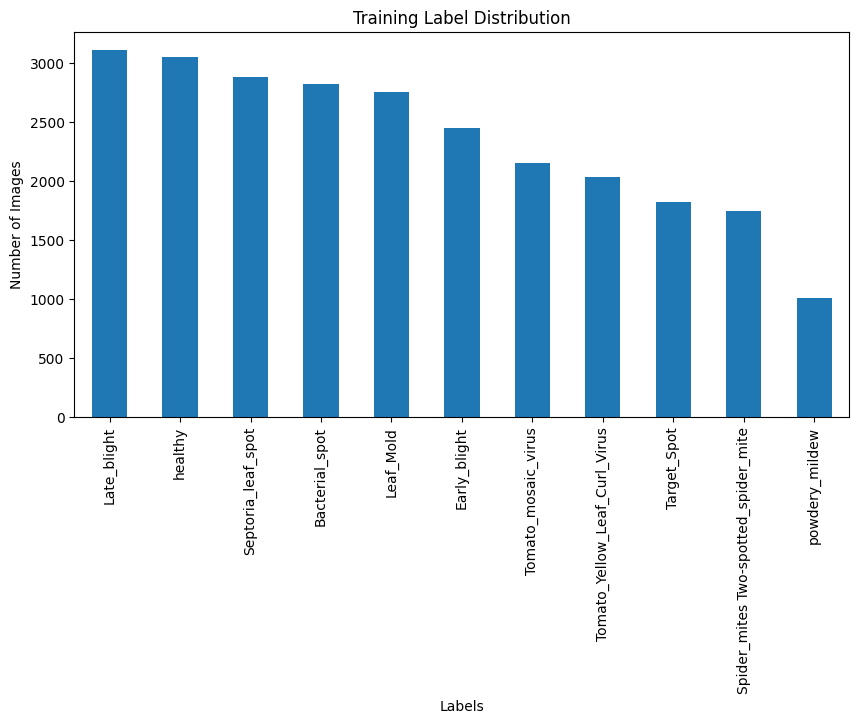


Validation Dataset Label Counts:
label
healthy                                 805
Late_blight                             792
Septoria_leaf_spot                      746
Leaf_Mold                               739
Bacterial_spot                          732
Early_blight                            643
Tomato_mosaic_virus                     584
Tomato_Yellow_Leaf_Curl_Virus           498
Target_Spot                             457
Spider_mites Two-spotted_spider_mite    435
powdery_mildew                          252
Name: count, dtype: int64


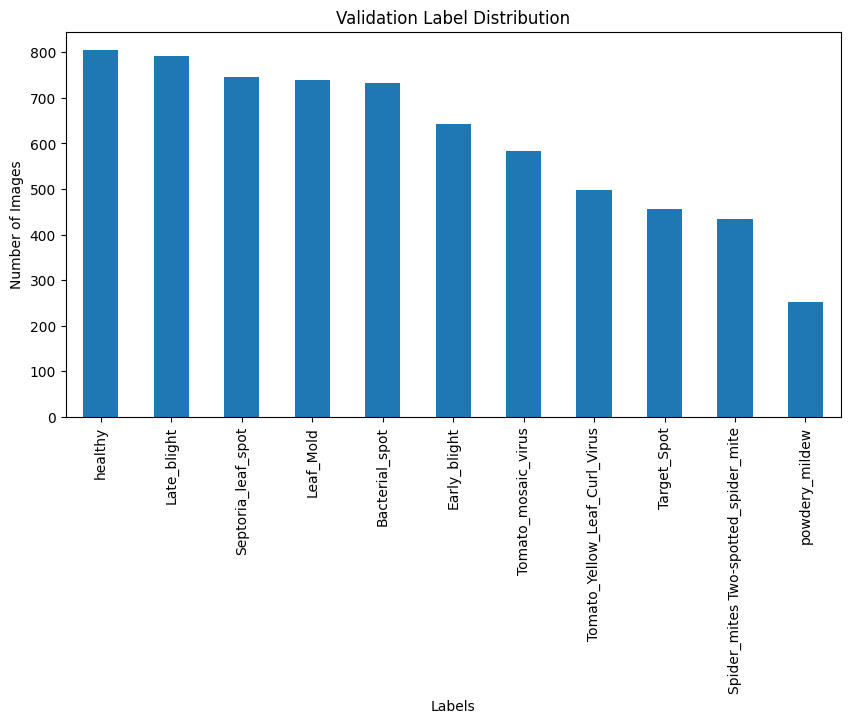

In [9]:
# Create training and validation DataFrames
train_df = create_train_df(cleaned_train_dir)
val_df = create_train_df(val_path)

# Plot label distribution
def plot_label_distribution(df, title):
    labels_distribution = df["label"].value_counts()
    labels_distribution.plot(kind="bar", figsize=(10, 5), title=title)
    plt.xlabel("Labels")
    plt.ylabel("Number of Images")
    plt.show()

print("Training Dataset Label Counts:")
print(train_df['label'].value_counts())
plot_label_distribution(train_df, "Training Label Distribution")

print("\nValidation Dataset Label Counts:")
print(val_df['label'].value_counts())
plot_label_distribution(val_df, "Validation Label Distribution")


In [10]:
print(train_df.head())
print(train_df.shape)

                                            filename    label
0  /kaggle/working/cleaned_train/healthy/healthy_...  healthy
1  /kaggle/working/cleaned_train/healthy/healthy_...  healthy
2  /kaggle/working/cleaned_train/healthy/healthy_...  healthy
3  /kaggle/working/cleaned_train/healthy/healthy_...  healthy
4  /kaggle/working/cleaned_train/healthy/healthy_...  healthy
(25851, 2)


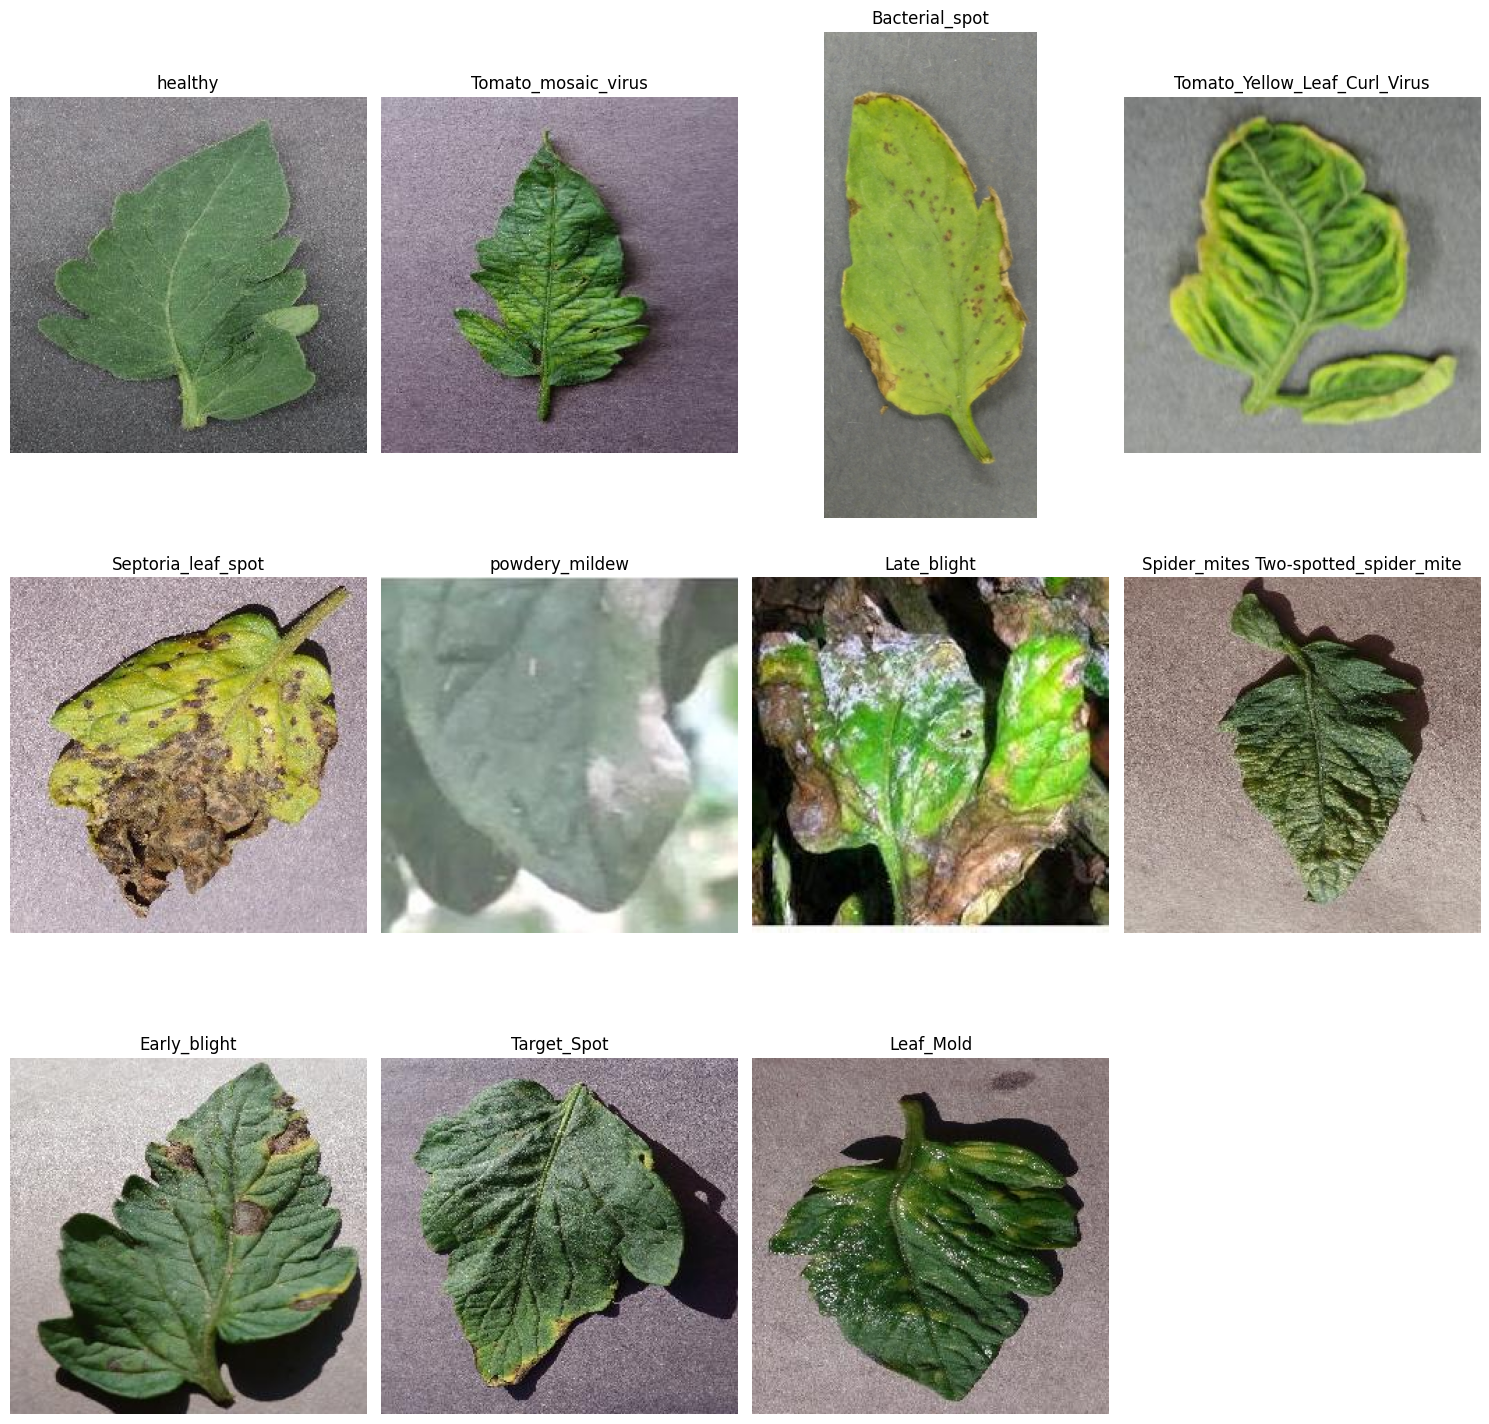

In [11]:
# Function to display sample images
def display_first_images(df, num_rows=3):
    classes = df["label"].unique()
    num_cols = (len(classes) + num_rows - 1) // num_rows
    plt.figure(figsize=(15, 5 * num_rows))
    for i, label in enumerate(classes):
        image_path = df[df["label"] == label]["filename"].iloc[0]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_first_images(train_df)

In [12]:
import os
import shutil
from PIL import Image

# Define source and destination directories
source_dir = cleaned_train_dir  # Replace with your actual directory path
dest_dir = 'data'  # Define a temporary directory for preprocessed images

# Counter for problematic files
cor_file_count = 0

# Create destination directory if not exists
if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)

# Loop through each label folder
for label in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, label)
    dest_path = os.path.join(dest_dir, label)

    # Remove existing directory if it exists
    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)
    os.mkdir(dest_path)

    # Convert and save images
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path)

            # Convert RGBA to RGB if necessary
            if img.mode == 'RGBA':
                img = img.convert('RGB')

            # Save as .jpeg with appropriate extension
            base_name, _ = os.path.splitext(filename)
            img.save(os.path.join(dest_path, base_name + '.jpeg'))
        except Exception as e:
            cor_file_count += 1
            print(f"Error converting {filename}: {e}")

if cor_file_count == 0:
    print("All files are converted to JPEG format successfully.")
else:
    print(f"{cor_file_count} files could not be converted.")


All files are converted to JPEG format successfully.


In [13]:
# Augmentation
def get_augmentor(source_folder, dest_folder):
    augmentor = Augmentor.Pipeline(source_folder, dest_folder)
    augmentor.rotate(probability=0.5, max_left_rotation=3, max_right_rotation=3)
    augmentor.flip_left_right(probability=0.3)
    augmentor.flip_top_bottom(probability=0.3)
    augmentor.rotate90(probability=0.3)
    augmentor.rotate180(probability=0.3)
    augmentor.rotate270(probability=0.3)
    augmentor.skew_tilt(probability=0.3)
    augmentor.skew_left_right(probability=0.3)
    augmentor.skew_top_bottom(probability=0.3)
    augmentor.skew_corner(probability=0.3)
    augmentor.skew(probability=0.5)
    augmentor.flip_left_right(probability=0.5)
    augmentor.flip_top_bottom(probability=0.3)
    augmentor.flip_random(probability=0.3)
    augmentor.random_brightness(probability=0.5, min_factor=0.4, max_factor=0.9)
    augmentor.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)
    augmentor.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
    augmentor.random_erasing(probability=0.5, rectangle_area=0.2)
    augmentor.zoom(probability=0.7, min_factor=1.1, max_factor=1.5)
    augmentor.sample(4000)  # Target 4000 samples per class
    return augmentor

dir_names = os.listdir(dest_dir)
for label in dir_names:
    src_folder = os.path.join(dest_dir, label)
    dest_folder = os.path.join(augmented_train_dir, label)
    get_augmentor(src_folder, dest_folder)


Initialised with 3051 image(s) found.
Output directory set to /kaggle/working/augmented_train/healthy.

Processing <PIL.Image.Image image mode=RGB size=227x227 at 0x78263058A3B0>: 100%|██████████| 4000/4000 [01:25<00:00, 46.56 Samples/s]   


Initialised with 2153 image(s) found.
Output directory set to /kaggle/working/augmented_train/Tomato_mosaic_virus.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x78264770D270>: 100%|██████████| 4000/4000 [01:29<00:00, 44.57 Samples/s]   


Initialised with 2826 image(s) found.
Output directory set to /kaggle/working/augmented_train/Bacterial_spot.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x78266C23D570>: 100%|██████████| 4000/4000 [01:12<00:00, 55.48 Samples/s]  


Initialised with 2039 image(s) found.
Output directory set to /kaggle/working/augmented_train/Tomato_Yellow_Leaf_Curl_Virus.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7826704CCFD0>: 100%|██████████| 4000/4000 [00:54<00:00, 73.44 Samples/s] 


Initialised with 2882 image(s) found.
Output directory set to /kaggle/working/augmented_train/Septoria_leaf_spot.

Processing <PIL.Image.Image image mode=RGB size=800x392 at 0x78266C3EFAF0>: 100%|██████████| 4000/4000 [01:38<00:00, 40.57 Samples/s]   


Initialised with 1004 image(s) found.
Output directory set to /kaggle/working/augmented_train/powdery_mildew.

Processing <PIL.Image.Image image mode=RGB size=227x227 at 0x78266C45A110>: 100%|██████████| 4000/4000 [00:38<00:00, 104.78 Samples/s]                 


Initialised with 3113 image(s) found.
Output directory set to /kaggle/working/augmented_train/Late_blight.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7827807D8820>: 100%|██████████| 4000/4000 [01:26<00:00, 46.48 Samples/s]   


Initialised with 1747 image(s) found.
Output directory set to /kaggle/working/augmented_train/Spider_mites Two-spotted_spider_mite.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7826705EBF70>: 100%|██████████| 4000/4000 [00:45<00:00, 88.68 Samples/s] 


Initialised with 2455 image(s) found.
Output directory set to /kaggle/working/augmented_train/Early_blight.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x78266C35CEB0>: 100%|██████████| 4000/4000 [01:24<00:00, 47.06 Samples/s]   


Initialised with 1827 image(s) found.
Output directory set to /kaggle/working/augmented_train/Target_Spot.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x78266E05A620>: 100%|██████████| 4000/4000 [00:46<00:00, 85.62 Samples/s] 


Initialised with 2754 image(s) found.
Output directory set to /kaggle/working/augmented_train/Leaf_Mold.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x78266C13CC70>: 100%|██████████| 4000/4000 [01:08<00:00, 58.64 Samples/s]   


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = '/kaggle/working/augmented_train1'
valid_dir = '/kaggle/input/tomato/valid'

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image data to [0, 1]
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zooms
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'  # Fill pixels that are lost during transformation
)

# Preprocessing for validation data (no augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data


In [29]:
# Train-test split
X = train_df["filename"]
y = train_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_df = pd.DataFrame(X_train).rename(columns={0: "filename"})
train_df["label"] = y_train
test_df = pd.DataFrame(X_test).rename(columns={0: "filename"})
test_df["label"] = y_test

# Parameters
IMG_SIZE = 256
BATCH_SIZE = 32

In [30]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Corrected print statements
print(f"Train generator classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Train generator batch shape: {next(train_generator)[0].shape}")


Found 13235 validated image filenames belonging to 11 classes.
Found 6683 validated image filenames belonging to 11 classes.
Train generator classes: 11
Class indices: {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}
Train generator batch shape: (32, 256, 256, 3)


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale=1./255,  # Normalize image data to [0, 1]
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zooms
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'  # Fill pixels that are lost during transformation
)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen  = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)


Found 13235 validated image filenames belonging to 11 classes.
Found 6683 validated image filenames belonging to 11 classes.
Found 3309 validated image filenames belonging to 11 classes.
{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}
{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}
{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


In [35]:
IMG_SIZE=256
BATCH_SIZE=32
Epochs=50
NUM_CLASSES = 11

In [37]:
# Print the shape of one batch from the generators
train_batch = next(train_generator)  # Get a single batch
valid_batch = next(val_generator)  # Get a single batch

# Print the shape of images and labels in the batch
print(f"Train batch shape: {train_batch[0].shape}")  # The images in the batch
print(f"Validation batch shape: {valid_batch[0].shape}")  # The images in the batch


Train batch shape: (32, 256, 256, 3)
Validation batch shape: (32, 256, 256, 3)


In [84]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model Architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, activation='relu')(x)  # Increased number of neurons
x = Dropout(0.5)(x)  # Increased dropout rate
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)  # Add another dropout layer for regularization
predictions = Dense(11, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Optimizer
optimizer = Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for Overfitting Mitigation
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Model Training

In [85]:
# Display the model's architecture
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 256, 256, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,416,942 (16.85 MB)

 Trainable params: 4,372,359 (16.68 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [86]:
import torch
if torch.cuda.is_available():
     device = "cuda"
else:
    device = "cpu"
device 
import tensorflow as tf

# Check for GPU devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available. TensorFlow will use it.")
else:
    print("GPU not found. TensorFlow will use CPU.")
import tensorflow as tf

# Force TensorFlow to run on GPU 0 (if available)
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=50,  # Increased epochs to let early stopping decide
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )
train_loss,train_acc=model.evaluate(train_generator)

print('Training Accuracy: {:.2f}%'.format(train_acc * 100))
print('Training Loss: {:.2f}'.format(train_loss*100))

val,acc=model.evaluate(test_generator)
print('Test Accuracy: {:.2f}%'.format(acc * 100))
print('Test Loss: {:.2f}%'.format(val*100))



GPU is available. TensorFlow will use it.
Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 301s 583ms/step - accuracy: 0.4426 - loss: 1.7898 - val_accuracy: 0.0676 - val_loss: 3.3761 - learning_rate: 0.0010
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 206s 489ms/step - accuracy: 0.8188 - loss: 0.5705 - val_accuracy: 0.8338 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 207s 492ms/step - accuracy: 0.8664 - loss: 0.4266 - val_accuracy: 0.9180 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 210s 499ms/step - accuracy: 0.9008 - loss: 0.3164 - val_accuracy: 0.9418 - val_loss: 0.1840 - learning_rate: 0.0010
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 215s 513ms/step - accuracy: 0.9169 - loss: 0.2695 - val_accuracy: 0.9410 - val_loss: 0.2032 - learning_rate: 0.0010
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 214s 510ms/step - accuracy: 0.9288 - loss: 0.2342 - val_accuracy: 0.9559 - val_loss: 0.1497 - learning_rate: 0.0010
Epoch 7/50
414/414 ━━━

104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step


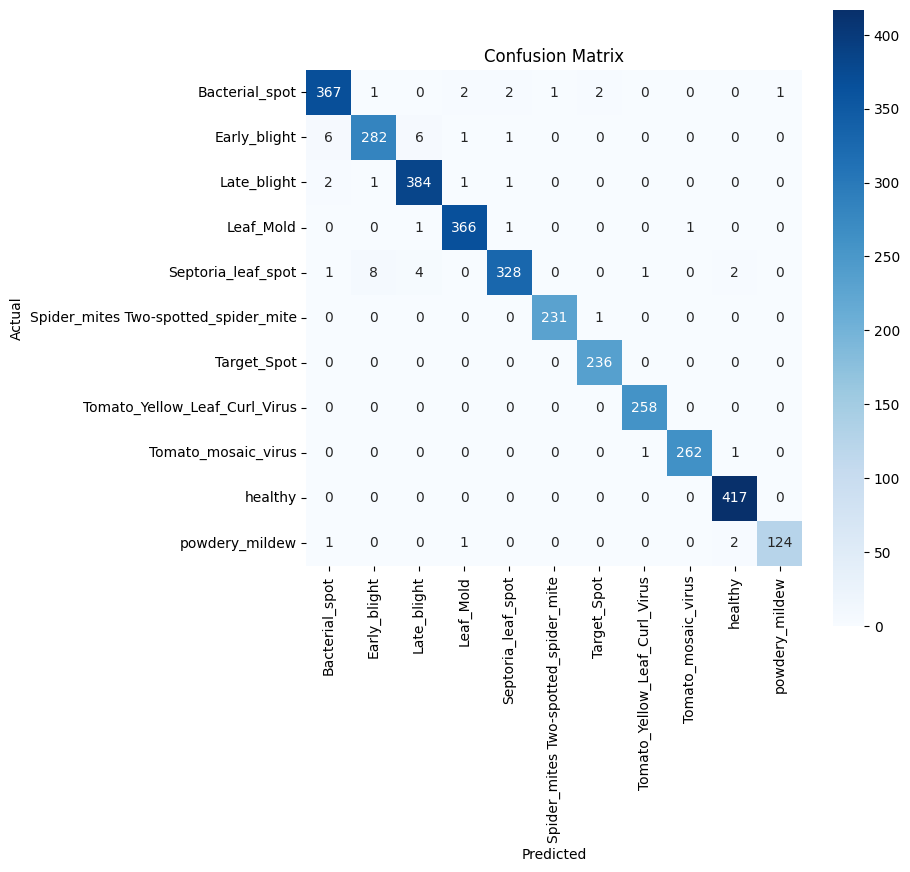

In [87]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(true_classes, y_pred_classes, average='weighted')
recall = recall_score(true_classes, y_pred_classes, average='weighted')
f1 = f1_score(true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(true_classes, y_pred_classes)

# Print metrics
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")



Precision: 0.9836817459842366
Recall (Sensitivity): 0.9836808703535811
F1 Score: 0.9836289380612898
Accuracy: 0.9836808703535811


In [89]:
from sklearn.metrics import jaccard_score, hamming_loss
import numpy as np


y_true = val_generator.classes  # True labels from the validation generator
y_pred_prob = model.predict(val_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Jaccard Index (macro-average)
jaccard = jaccard_score(y_true, y_pred, average='macro')
print(f"Jaccard Index (Macro): {jaccard}")

# Hamming Loss
hamming = hamming_loss(y_true, y_pred)
print(f"Hamming Loss: {hamming}")


209/209 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step
Jaccard Index (Macro): 0.9657661758408078
Hamming Loss: 0.017956007780936704


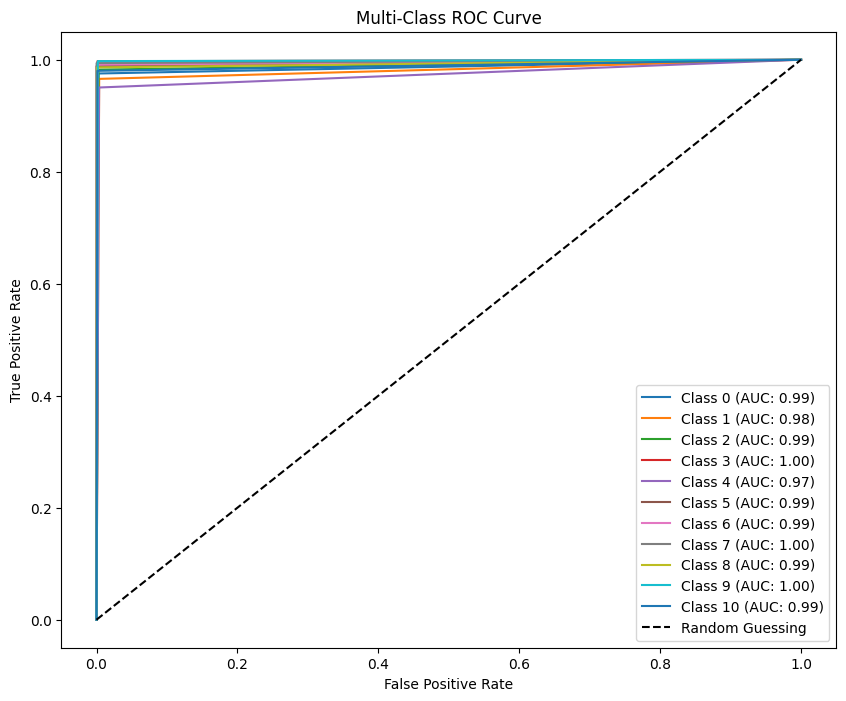

In [95]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from scipy.special import softmax

# Example inputs (replace with actual data)
# y_true: True class indices (1D array)
# y_pred: Predicted logits or probabilities (1D or 2D array)
y_true = np.array(y_true)  # True labels
y_pred = np.array(y_pred)  # Predictions (raw logits or probabilities)

# Ensure `y_pred` contains probabilities
if y_pred.ndim == 1:  # If 1D, convert to probabilities
    y_pred = to_categorical(y_pred, num_classes=len(set(y_true)))
elif y_pred.ndim == 2 and y_pred.shape[1] != len(set(y_true)):
    y_pred = softmax(y_pred, axis=1)  # Convert logits to probabilities

# Binarize true labels for multi-class ROC
n_classes = y_pred.shape[1]
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])  # Compute FPR and TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, label=f'Class {i} (AUC: {roc_auc:.2f})')

# Plot diagonal for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Add titles and labels
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.show()


In [96]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels (one-hot encoding)
n_classes = len(set(y_true))  # Replace with the number of classes
y_true_bin = label_binarize(y_true, classes=range(n_classes))  # y_true is the true labels

# Calculate AUC for each class
auc_scores = []
for i in range(n_classes):
    auc_score = roc_auc_score(y_true_bin[:, i], y_pred[:, i])  # y_pred is the predicted probabilities
    auc_scores.append(auc_score)
    print(f"AUC for Class {i}: {auc_score:.4f}")

# Micro-average AUC
auc_micro = roc_auc_score(y_true_bin, y_pred, average="micro")
print(f"Micro-Averaged AUC: {auc_micro:.4f}")

# Macro-average AUC
auc_macro = roc_auc_score(y_true_bin, y_pred, average="macro")
print(f"Macro-Averaged AUC: {auc_macro:.4f}")


AUC for Class 0: 0.9863
AUC for Class 1: 0.9810
AUC for Class 2: 0.9897
AUC for Class 3: 0.9980
AUC for Class 4: 0.9733
AUC for Class 5: 0.9943
AUC for Class 6: 0.9949
AUC for Class 7: 0.9969
AUC for Class 8: 0.9928
AUC for Class 9: 0.9978
AUC for Class 10: 0.9895
Micro-Averaged AUC: 0.9901
Macro-Averaged AUC: 0.9904


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


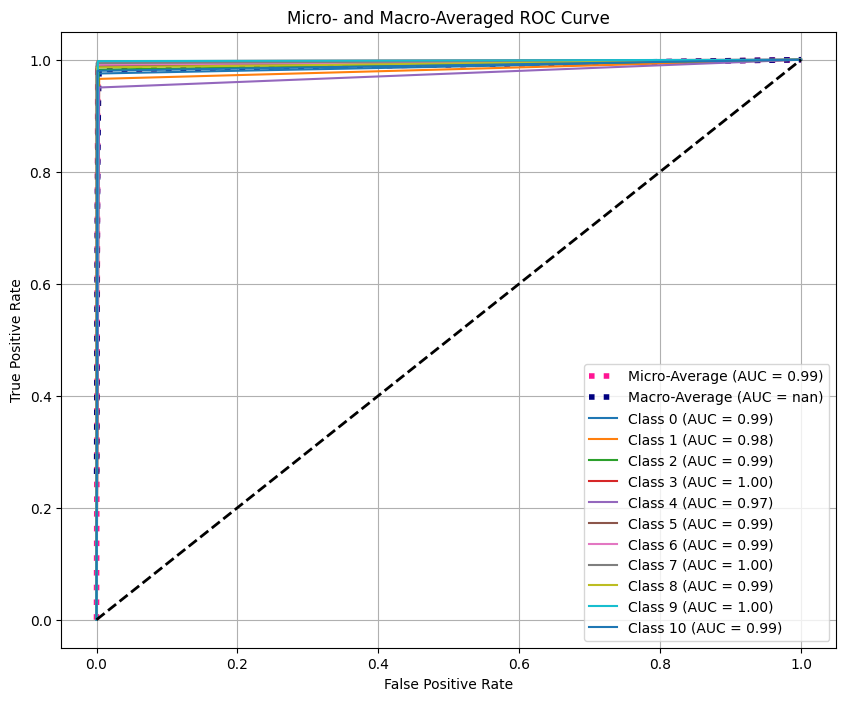

In [99]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Ensure `y_true_bin` and `y_pred` are correctly shaped
assert y_true_bin.shape == y_pred.shape, "Shapes of y_true_bin and y_pred must match"
n_classes = y_true_bin.shape[1]

# Initialize variables
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    if np.sum(y_true_bin[:, i]) > 0:  # Check if the class is present in true labels
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        print(f"Class {i} is missing in the data")

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
mean_tpr = np.zeros_like(all_fpr)
for i in fpr:
    mean_tpr += interp1d(fpr[i], tpr[i], kind='linear', fill_value="extrapolate")(all_fpr)
mean_tpr /= len(fpr)  # Average over present classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-Average (AUC = {roc_auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(all_fpr, mean_tpr, label=f'Macro-Average (AUC = {roc_auc_macro:.2f})', color='navy', linestyle=':', linewidth=4)

# Add ROC curves for each class
for i in fpr:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Finalize plot
plt.title('Micro- and Macro-Averaged ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


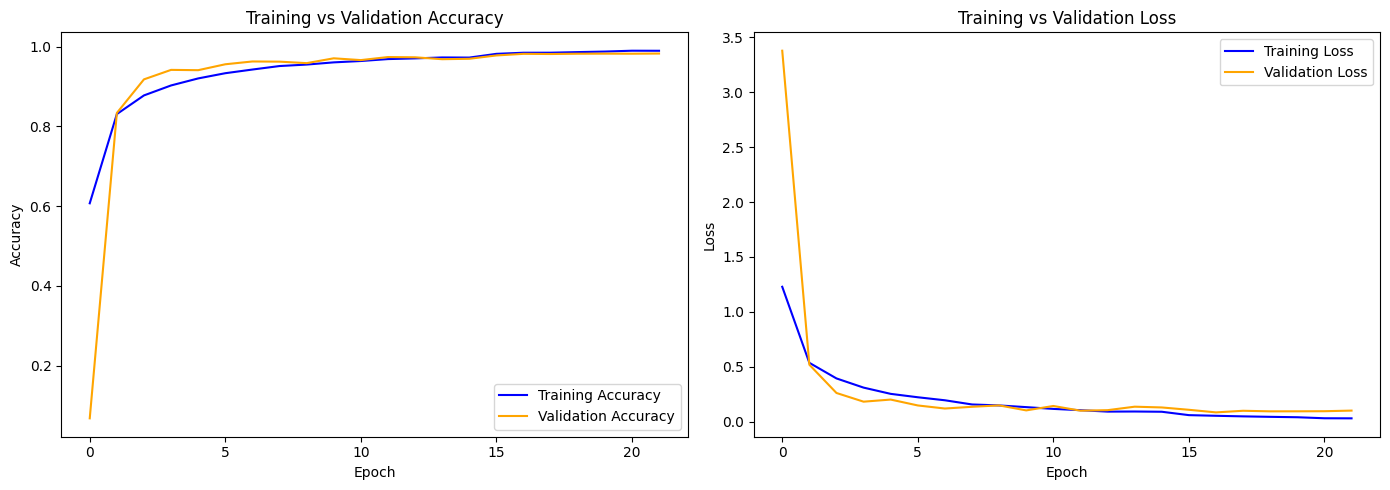

In [100]:
import matplotlib.pyplot as plt
# Extract metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure for accuracy and loss comparison
plt.figure(figsize=(14, 5))

# Plot Training and Validation Accuracy in the same plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss in the same plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [101]:
# Compute overall accuracy
accuracy = accuracy_score(true_classes, y_pred_classes)
print(f"Overall Accuracy: {accuracy}")

# Compute class-wise metrics
precision = precision_score(true_classes, y_pred_classes, average=None)
recall = recall_score(true_classes, y_pred_classes, average=None)
f1 = f1_score(true_classes, y_pred_classes, average=None)

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Create a DataFrame to display the results in a table format
metrics_df_EffNet = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall (Sensitivity)': recall,
    'F1 Score': f1
})

Overall Accuracy: 0.9836808703535811


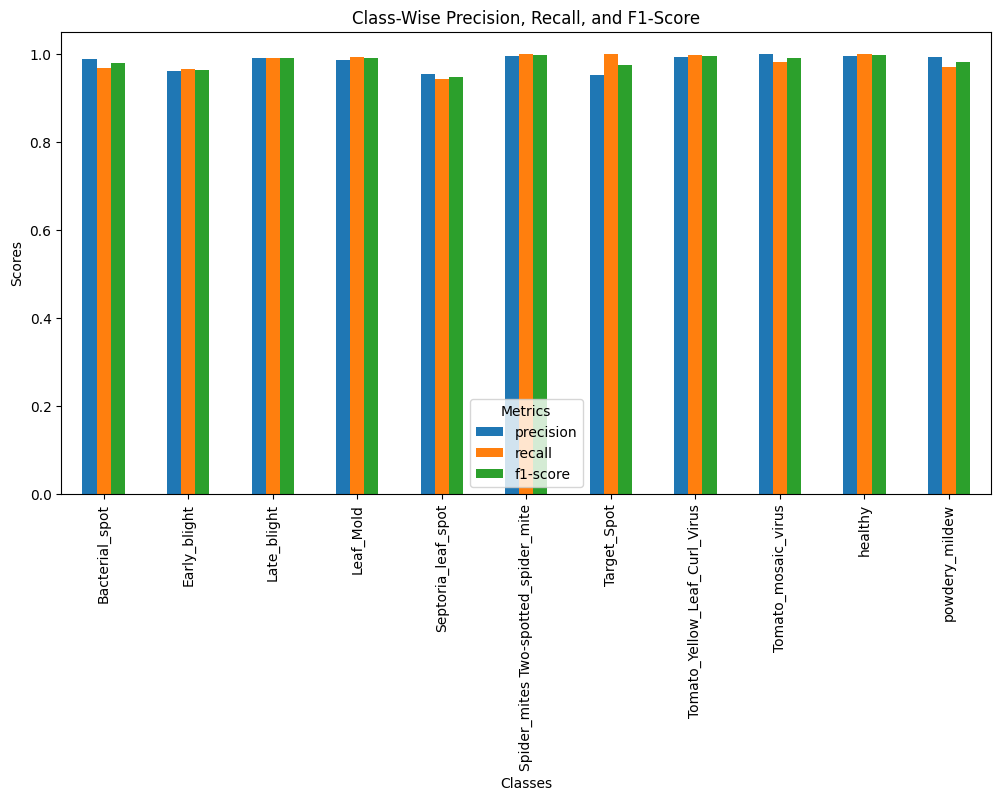

In [102]:
# Extract precision, recall, and F1-score from classification report
metrics = ['precision', 'recall', 'f1-score']
class_metrics = report_df.loc[list(test_generator.class_indices.keys()), metrics]

# Plot
class_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Class-Wise Precision, Recall, and F1-Score')
plt.ylabel('Scores')
plt.xlabel('Classes')
plt.legend(title='Metrics')
plt.show()


In [103]:
metrics_df_EffNet

Class  Precision  Recall (Sensitivity)  \
0                         Bacterial_spot   0.973475              0.976064   
1                           Early_blight   0.965753              0.952703   
2                            Late_blight   0.972152              0.987147   
3                              Leaf_Mold   0.986523              0.991870   
4                     Septoria_leaf_spot   0.984985              0.953488   
5   Spider_mites Two-spotted_spider_mite   0.995690              0.995690   
6                            Target_Spot   0.987448              1.000000   
7          Tomato_Yellow_Leaf_Curl_Virus   0.992308              1.000000   
8                    Tomato_mosaic_virus   0.996198              0.992424   
9                                healthy   0.988152              1.000000   
10                        powdery_mildew   0.992000              0.968750   

    F1 Score  
0   0.974768  
1   0.959184  
2   0.979592  
3   0.989189  
4   0.968981  
5   0.995690  
6   0.993684  
7   0.996139  
8   0.994307  
9   0.994041  
10  0.980237

In [105]:
# Verify dataset sizes
print(f"y_true shape: {len(y_true)}")
print(f"y_pred_classes shape: {len(y_pred_classes)}")

# Verify the test_generator size
print(f"Test samples: {test_generator.samples}")


y_true shape: 6683
y_pred_classes shape: 3309
Test samples: 3309


Updated y_true shape: 3309


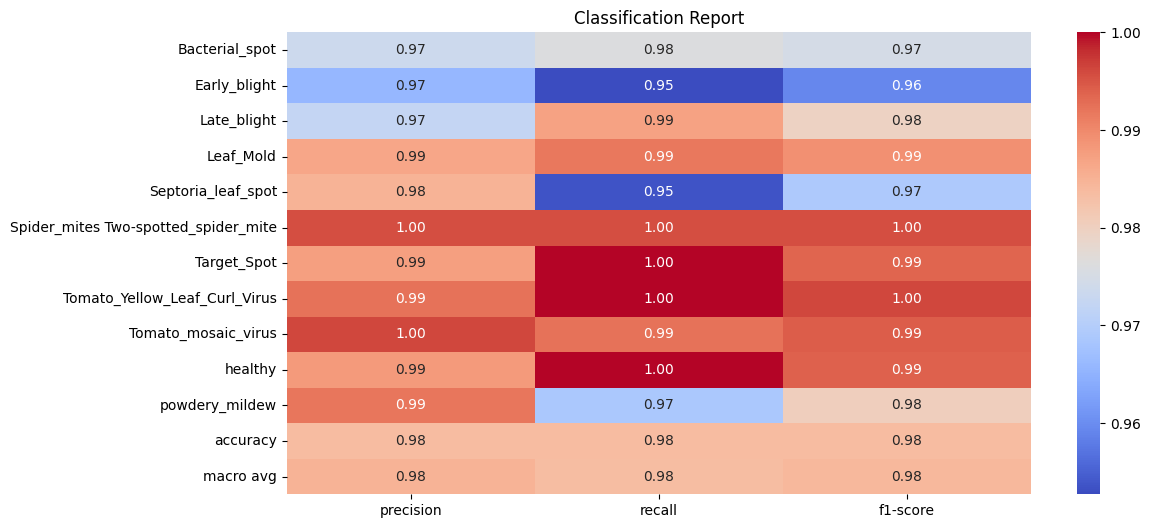

In [106]:
# Correct `y_true` using the test generator
y_true = test_generator.classes  # True labels directly from the generator
print(f"Updated y_true shape: {len(y_true)}")

# Confirm lengths now match
if len(y_true) != len(y_pred_classes):
    raise ValueError(f"Inconsistent lengths: y_true={len(y_true)}, y_pred_classes={len(y_pred_classes)}")

# Proceed with generating the classification report
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_names = list(test_generator.class_indices.keys())  # Extract class names
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Visualize the report
plt.figure(figsize=(12, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Classification Report')
plt.show()


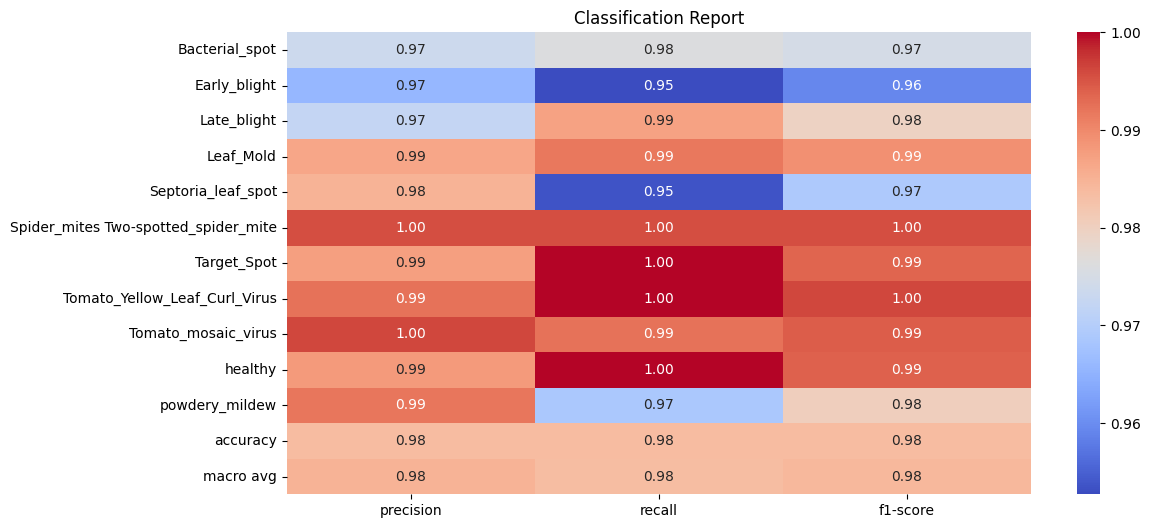

In [107]:
from sklearn.metrics import classification_report
import pandas as pd

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot the report
plt.figure(figsize=(12, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Classification Report')
plt.show()


In [108]:
metrics_df_EffNet.to_csv('EFNET_individual_class_metrics.csv')

In [109]:
model.save('Tomato.h5')

In [110]:
tomato_model=load_model('Tomato.h5')

In [112]:
from tensorflow.keras.preprocessing import image
import numpy as np
img_path='/kaggle/input/tomato/valid/Bacterial_spot/014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_Bact.Sp 2971.JPG'
# Define the target image size
IMG_SIZE = 256

def preprocess_single_image(img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    
    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)
    
    # Normalize pixel values to [0, 1] range
    img_array /= 255.0
    
    # Expand dimensions to match the model's expected input shape
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

# Example: Preprocess an image and predict using the model
img_data = preprocess_single_image(img_path)

predictions = tomato_model.predict(img_data)

# Get the predicted class index
predicted_class = np.argmax(predictions, axis=-1)

# Assuming class labels from your dataset
class_labels = ['Bacterial Spot', 'Early Blight', 'Late Blight','Leaf Mold','Septoria Leaf Spot','Target Spot','Tomato Yellow Leaf Curl Virus','Tomato Mosaic Virus','Healthy','Powdery_Mildew','Spotted Spider Mite' ]  # Replace with actual class labels
predicted_class_name = class_labels[predicted_class[0]]

print(f"Predicted class index: {predicted_class[0]}")
print(f"Predicted class name: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class index: 0
Predicted class name: Bacterial Spot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

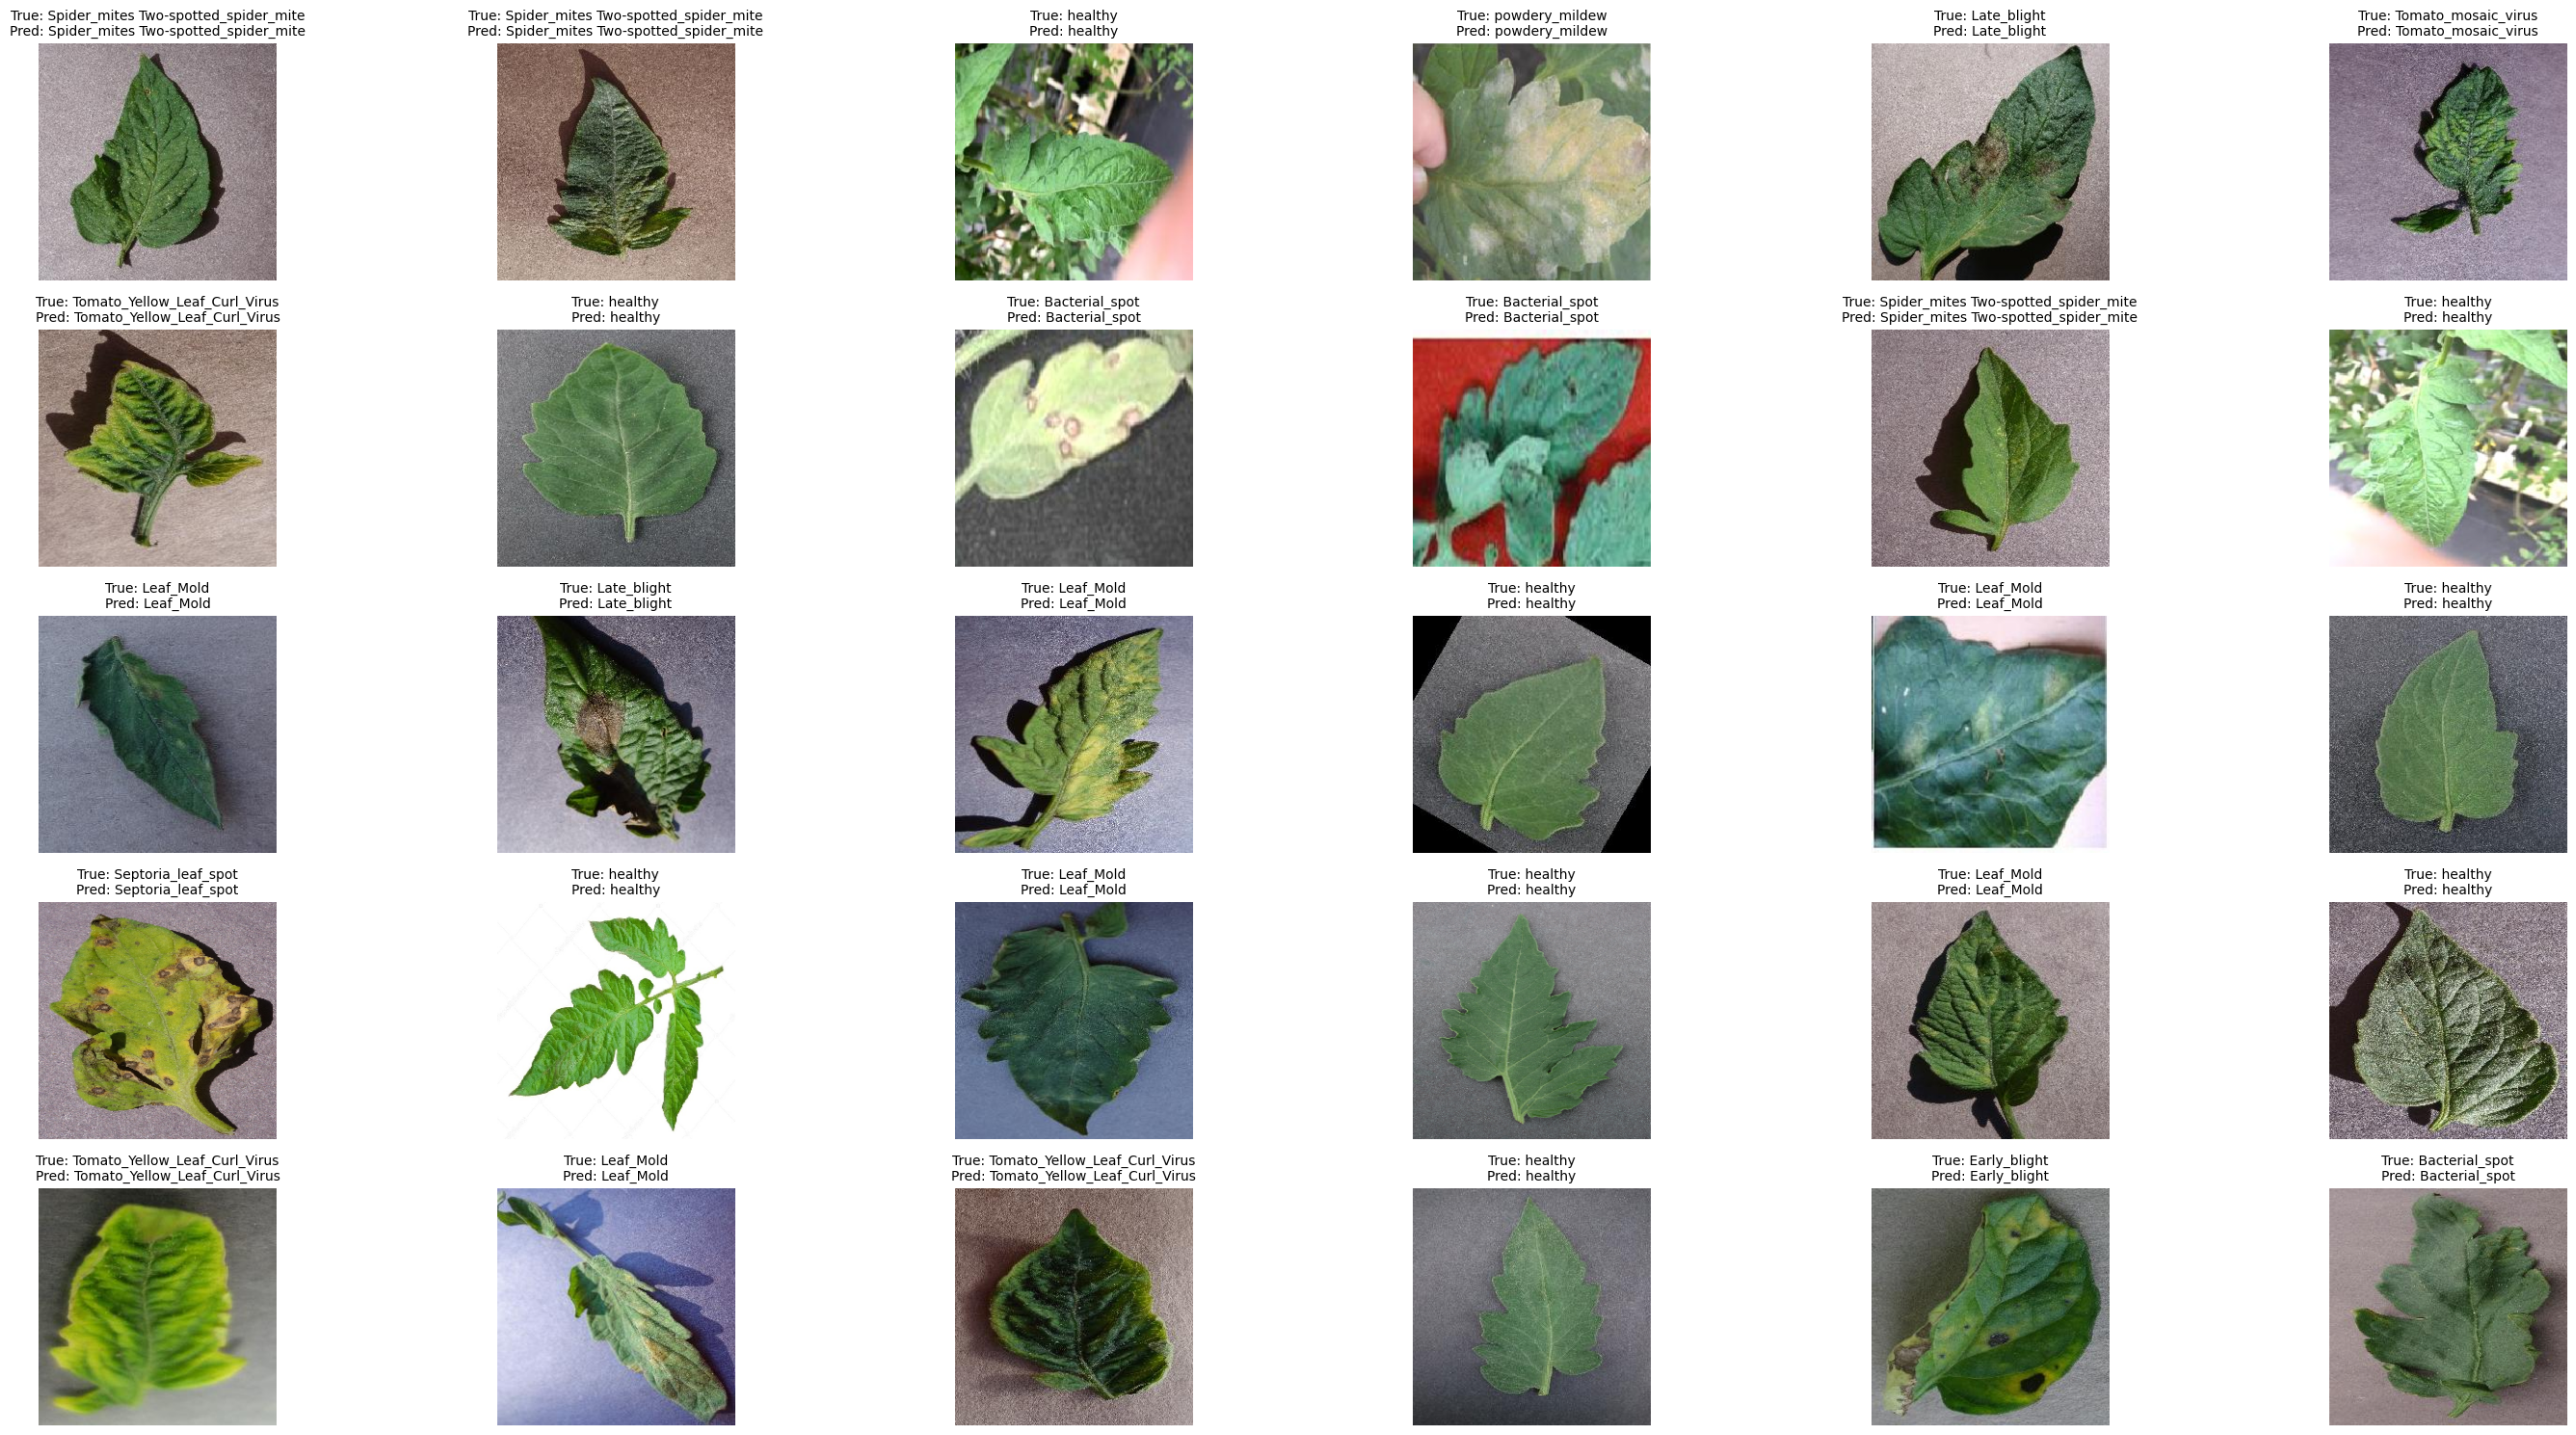

In [113]:
import os
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define constants
IMG_SIZE = 256
VALIDATION_PATH = '/kaggle/input/tomato/valid'
CLASS_LABELS = [
    'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold',
    'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 
    'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew'
]  # Ensure these match your dataset labels


# Preprocess a single image
def preprocess_single_image(img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)
    # Normalize pixel values to [0, 1] range
    img_array /= 255.0
    # Expand dimensions to match the model's expected input shape
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array


# Randomly sample images from the validation dataset
def get_random_images(validation_path, num_samples=30):  # Adjusted to 30 samples
    all_images = []
    class_names = os.listdir(validation_path)  # List all class directories
    for class_name in class_names:
        class_dir = os.path.join(validation_path, class_name)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        all_images.extend(images)
    return random.sample(all_images, num_samples)


# Predict and display images with labels
def predict_and_display_images(model, image_paths):
    plt.figure(figsize=(30, 15))  # Adjusted figure size for 30 images
    for i, img_path in enumerate(image_paths):
        # Preprocess the image
        original_img, img_data = preprocess_single_image(img_path)
        # Predict the class
        predictions = model.predict(img_data)
        predicted_class = np.argmax(predictions, axis=-1)
        predicted_label = CLASS_LABELS[predicted_class[0]]

        # Extract true label from the folder name
        true_label = img_path.split('/')[-2]

        # Display the image
        plt.subplot(5, 6, i + 1)  # Updated for a 5x6 grid layout
        plt.imshow(original_img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Get 30 random images from the validation dataset
random_images = get_random_images(VALIDATION_PATH, num_samples=30)

# Predict and display
predict_and_display_images(tomato_model, random_images)




In [114]:
tomato_model.save_weights('tomato_model.weights.h5')

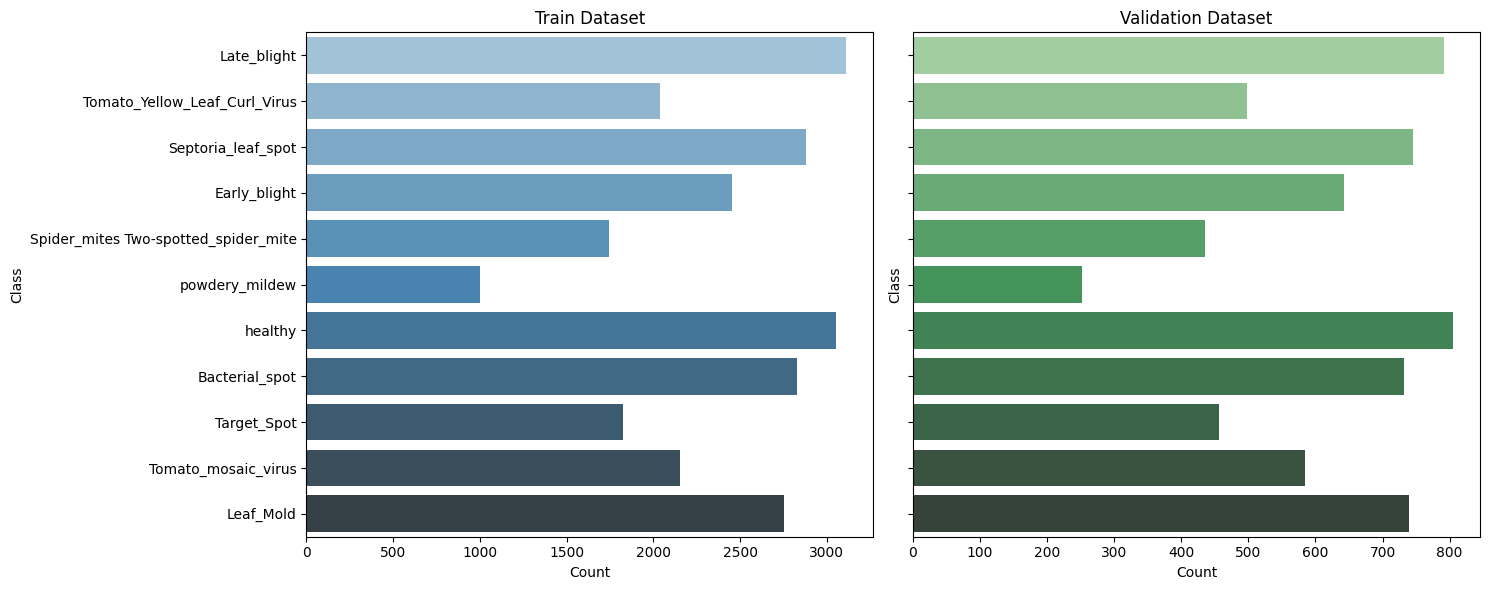

In [116]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to the train and validation directories
train_dir = "/kaggle/input/tomato/train"
valid_dir = "/kaggle/input/tomato/valid"

# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get counts for train and validation datasets
train_counts = count_images(train_dir)
valid_counts = count_images(valid_dir)

# Convert counts to DataFrames for plotting
train_df = pd.DataFrame(list(train_counts.items()), columns=["Class", "Count"])
valid_df = pd.DataFrame(list(valid_counts.items()), columns=["Class", "Count"])

# Plot the data
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Train dataset
sns.barplot(x="Count", y="Class", data=train_df, ax=axes[0], palette="Blues_d")
axes[0].set_title("Train Dataset")

# Validation dataset
sns.barplot(x="Count", y="Class", data=valid_df, ax=axes[1], palette="Greens_d")
axes[1].set_title("Validation Dataset")

plt.tight_layout()
plt.show()


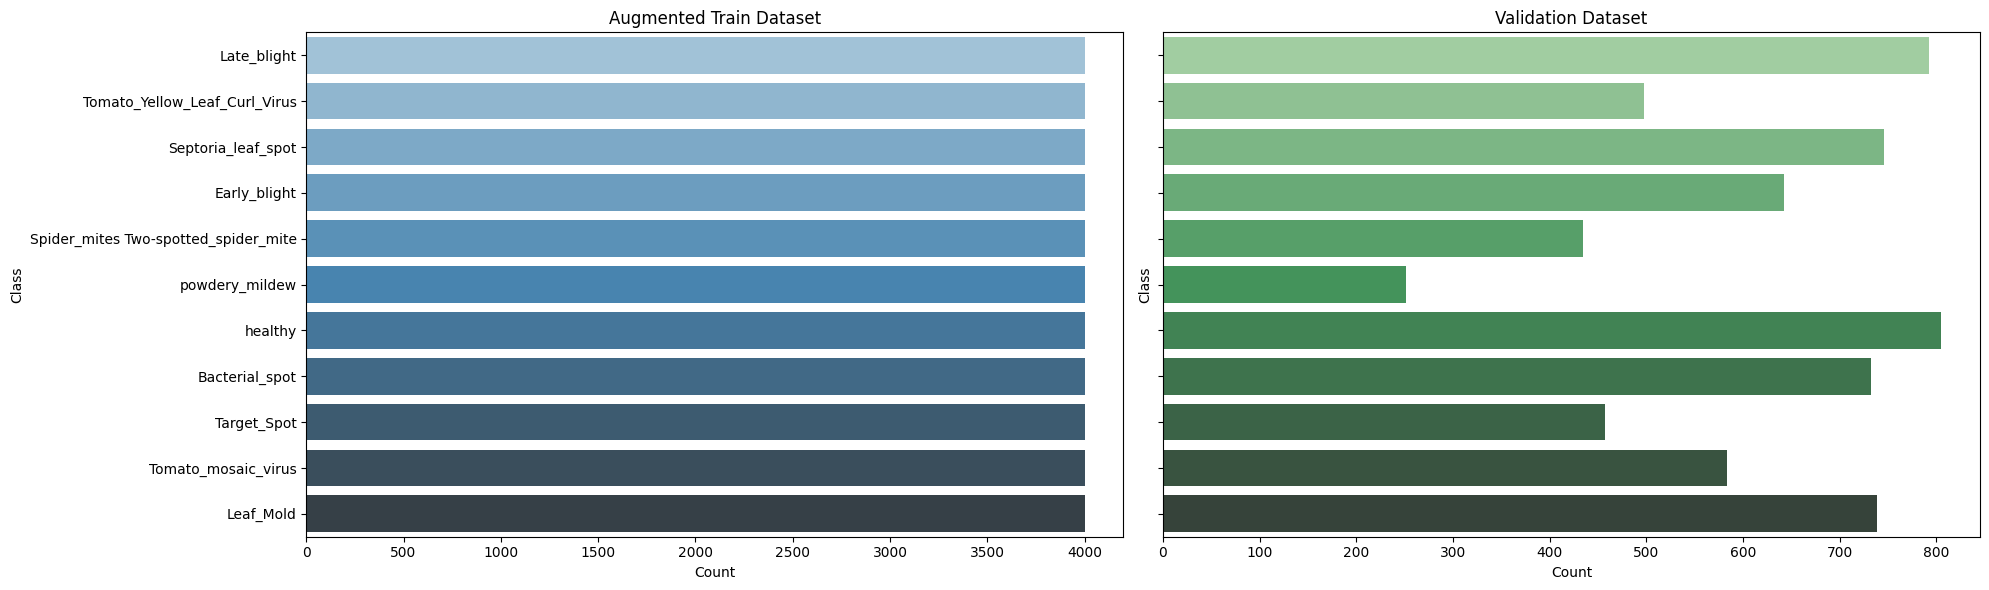

In [125]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Paths to the augmented dataset directories
augmented_train_dir = "/kaggle/working/augmented_train"  # Assuming this is your augmented training data directory
valid_dir = '/kaggle/input/tomato/valid'  # Your original validation dataset directory

# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get counts for the augmented train, validation, and test datasets
train_counts = count_images(augmented_train_dir)

# Assuming you've already split the augmented training data (80% train, 20% test)
# We simulate this by splitting the class-wise directories
all_classes = os.listdir(augmented_train_dir)
test_counts = {}  # To store test counts

# Split each class into test and train
for class_name in all_classes:
    class_path = os.path.join(augmented_train_dir, class_name)
    # Get all files in the class
    all_images = os.listdir(class_path)


# Get validation counts
valid_counts = count_images(valid_dir)

# Convert counts to DataFrames for plotting
train_df = pd.DataFrame(list(train_counts.items()), columns=["Class", "Count"])
valid_df = pd.DataFrame(list(valid_counts.items()), columns=["Class", "Count"])


# Plot the data
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Train dataset (after augmentation)
sns.barplot(x="Count", y="Class", data=train_df, ax=axes[0], palette="Blues_d")
axes[0].set_title("Augmented Train Dataset")

# Validation dataset
sns.barplot(x="Count", y="Class", data=valid_df, ax=axes[1], palette="Greens_d")
axes[1].set_title("Validation Dataset")


plt.tight_layout()
plt.show()


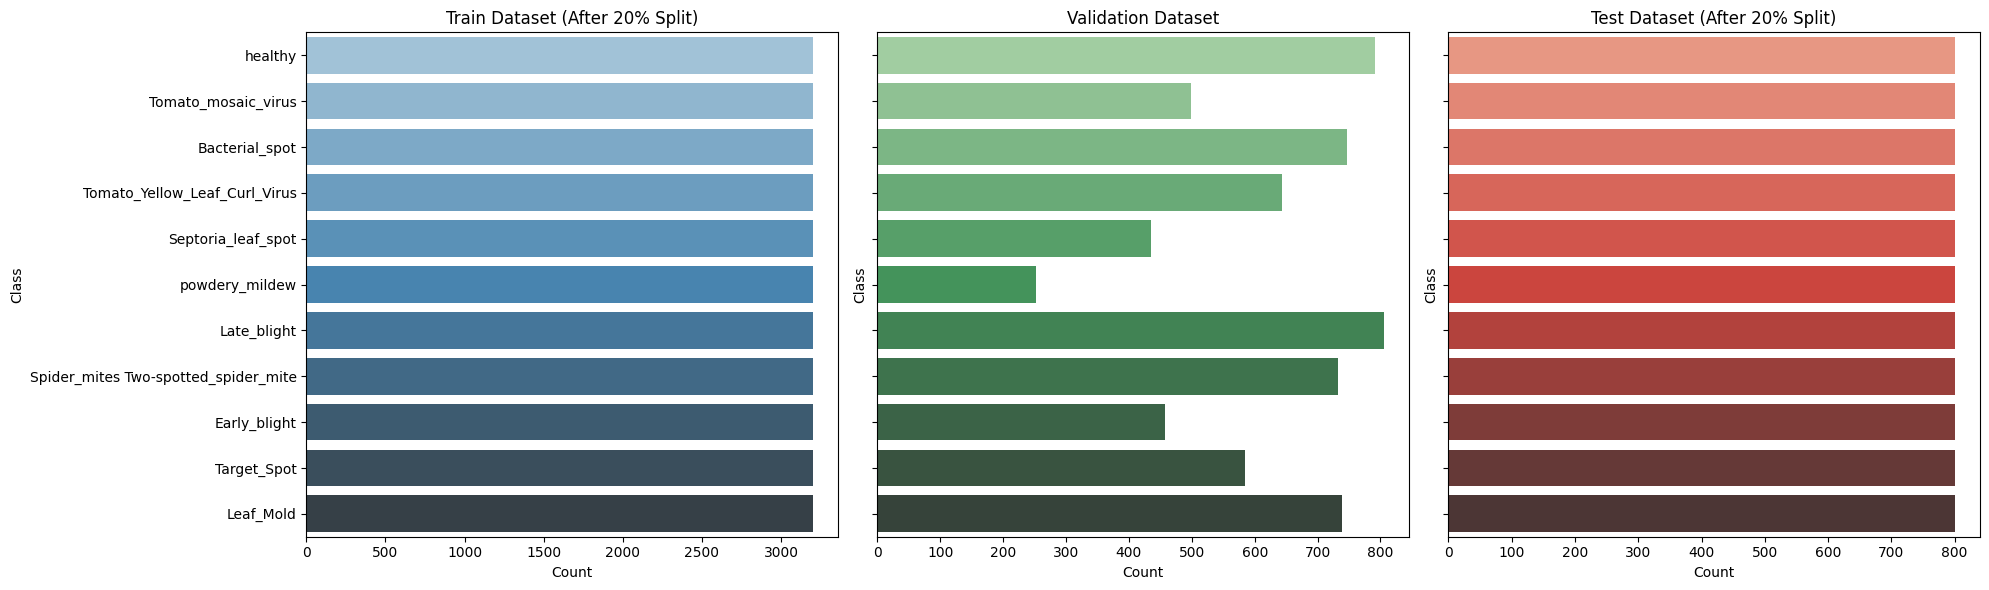

In [123]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Paths to the augmented dataset directories
augmented_train_dir = "/kaggle/working/augmented_train"  # Assuming this is your augmented training data directory
valid_dir = '/kaggle/input/tomato/valid'  # Your original validation dataset directory

# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get counts for the augmented train and validation datasets
train_counts = count_images(augmented_train_dir)

# Assuming you've already split the augmented training data (80% train, 20% test)
# We simulate this by splitting the class-wise directories
train_split_counts = {}
test_counts = {}  # To store test counts

# Split each class into test and train (80% train, 20% test)
for class_name in train_counts.keys():
    class_path = os.path.join(augmented_train_dir, class_name)
    # Get all files in the class
    all_images = os.listdir(class_path)
    # Split into train and test (80% train, 20% test)
    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
    train_split_counts[class_name] = len(train_images)
    test_counts[class_name] = len(test_images)

# Get validation counts
valid_counts = count_images(valid_dir)

# Convert counts to DataFrames for plotting
train_df = pd.DataFrame(list(train_split_counts.items()), columns=["Class", "Count"])
valid_df = pd.DataFrame(list(valid_counts.items()), columns=["Class", "Count"])
test_df = pd.DataFrame(list(test_counts.items()), columns=["Class", "Count"])

# Plot the data
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Train dataset (after 20% split)
sns.barplot(x="Count", y="Class", data=train_df, ax=axes[0], palette="Blues_d")
axes[0].set_title("Train Dataset (After 20% Split)")

# Validation dataset
sns.barplot(x="Count", y="Class", data=valid_df, ax=axes[1], palette="Greens_d")
axes[1].set_title("Validation Dataset")

# Test dataset (after 20% split)
sns.barplot(x="Count", y="Class", data=test_df, ax=axes[2], palette="Reds_d")
axes[2].set_title("Test Dataset (After 20% Split)")

plt.tight_layout()
plt.show()
